# Project \#1:
What Determines Business' Yelp Ratings in Toronto?  
*by Thomas Keough*

## Introduction

With broad access to review data on websites, online business ratings are becoming increasingly relevant to business owners. This is especially true of service-oriented businesses, such as restaurants, hair salons, and hotels. Customers prefer to visit well-reviewed businesses, which means businesses should care about their online ratings. By extension, this means that both businesses and customers are interested in identifying what causes a business to earn good reviews. This analysis seeks to understand the determinants of online business ratings by using metrics available on Yelp, one of the most popular websites for reviews.

This analysis using data acquired from Kaggle.com. The data was initially published by Yelp as part of a dataset challenge. It was last updated in August 2017 and includes data from 11 cities in four countries, including the USA and Canada. Additional Yelp data on prices is gathered using the Yelp Fusion API. Population data is acquired from Statistics Canada. The dataset is composed of files pertaining to business attributes, hours of operation, reviews, check-ins, tips, and users. This analysis merges the files for business attributes, hours of operation, check-ins, prices, and population for businesses in Toronto, Ontario. The dependent variable is business ratings, measured in Yelp stars. The chosen covariates are business' total number of Yelp reviews, total weekly hours of operation, daily average number of Yelp check-ins, business prices as measured by the number of dollar signs on Yelp, and population by forward sortation area (FSA).

The results of this analysis demonstrate that the number of reviews, hours of operation, and number of check-ins are all positively correlated with business ratings. The effect of the number of reviews depends in part on the type of business. By splitting the observations into three categories (shops, restaurants, other), restaurants have the lowest average rating while shops have the highest. Neither business price levels nor the population of a business's FSA appears to be correlated with businesses ratings. In order to determine the strength and magnitude of these correlations, a multiple regression analysis should be conducted.    

## Data Cleaning

*(i) Setting Up The Project*  
  
**Y: Business Rating ('stars')**  
This analysis seeks to identify the determinants of business ratings using quantitative data gathered from Yelp. The outcome variable is the business rating, which is referred to as "stars" in the dataset. This variable takes a value between 1 and 5. It is discrete data; potential values must be multiples of 0.5. This analysis includes three covariates of interest.

**X1: Number of Reviews ('review_count')**  
The first covariate is the total number of reviews for each business. It is discrete. The review system is an extremely prominent feature of Yelp and is used frequently, so the number of reviews should account for a significant proportion of the variation in business ratings. There are two valid hypotheses for the correlation between the number of reviews with business ratings. For instance, a business that has exceptionally good service can encourage Yelp users to leave positive reviews. This would suggest that the number of reviews is positively associated with business ratings. However, the opposite effect is also feasible; exceptionally poor service may encourage Yelp users to leave negative reviews, meaning the number of reviews would be negatively correlated with business ratings. The dominant hypothesis, should one exist, will manifest itself through an empirical analysis of the relationship between review count and ratings.

**X2: Number of Operating Hours per Week ('wk_op_hours')**  
The second covariate is the number of operating hours in a week for a business. Businesses differ largely in hours of operation on a day-to-day basis, so using the weekly total of operating hours will account for those differences across the days of the week. This variable will provide insight on the effect of customer access to businesses, which may be a component in evaluating business quality from the perspective of customers. There are several hypotheses for the direction of the relationship between operating hours and business ratings. It could be that businesses that are open longer throughout the week earn more reviews because they can serve more customers. Therefore, the direction of the relationship would be dependent on the ambiguous effect of the number of reviews on business ratings. Alternatively, businesses that are open for fewer hours per week may instill a sense of exclusivity in its customers. For example, fine dining venues, nightclubs, and other businesses that have limited weekly operating hours may observe more positive reviews because attendees feel exclusive.

**X3: Average Number of Check-ins per Day ('daily_checkin_avg')**  
The third covariate is the average number of Yelp check-ins per day. It is important to note that this calculation of the daily check-in average ignores days wherein businesses had zero check-ins. In other words, it is the average number of check-ins for days that had at least one check-in. "Checking in" is a Yelp feature that allows users to inform their Yelp following of the businesses they visit. When a user "checks in" to a business, their attendance is published on their profile. Users can also earn badges and special offers at businesses they check in at. These two components provide increased incentives for Yelp users to visit high-quality businesses; users can show off their attendance at a popular business and potentially earn discounts in the process. Comparatively, poor-quality businesses would have fewer check-ins since users would not want to publish their attendance at them. Therefore, this variable accounts for customer perception of businesses. Therefore, check-ins should be positively correlated with a business's ratings in theory. An OLS regression that utilizes this covariate and the number of reviews would provide insight on how the number of reviews affects a business's rating while holding constant the customers' perception of the business. This would provide insight on the causality of business ratings.

*(ii) Data Cleaning*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import json
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/yelp_business.csv')
df2 = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/yelp_checkin.csv')
df3 = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/yelp_business_hours.csv')

# make copies
bsn_df = df.copy()
checkin_df = df2.copy()
hours_df = df3.copy()

In [3]:
# build Toronto businesses dataframe:

# make a df for Toronto businesses
tor_bsn = bsn_df.loc[bsn_df['city'] == 'Toronto']

# generate a restaurant dummy
tor_bsn['restaurant'] = tor_bsn['categories'].str.contains('Restaurant').astype(int)

# generate a shops dummy
tor_bsn['shop'] = tor_bsn['categories'].str.contains('Shopping').astype(int)

# Incorporate check-in data:

# find average daily checkins for each business
all_checks = checkin_df.groupby('business_id').mean().rename(columns={'checkins': 'daily_checkin_avg'})

# inner join on tor_bsn to get checkin data for each business in Toronto
tor_bsn = tor_bsn.merge(all_checks, on='business_id')

# === Incorporate weekly operating hours: ===

# build a function to clean hours_df

def count_hours(operating_hours: str) -> float:
    """Returns a float given a string of the form "HH:MM-HH:MM" that contains a business's operating hours."""

    # if business is closed on the given day:
    if operating_hours == 'None':
        return 0.0 

    # '2000-01-01' is needed in the string that is converted to datetime to avoid being out of pandas' accepted date range
    hours = operating_hours.split('-')
    opn = pd.to_datetime('2000-01-01 ' + hours[0])
    close = pd.to_datetime('2000-01-01 ' + hours[1])

    # if the business is open past midnight:
    if close < opn:
        end_date = '2000-01-02'
    else:
        end_date = '2000-01-01'
    
    # calculate a timedelta that accounts for hours of operation past midnight
    window = pd.to_timedelta(pd.to_datetime(f'{end_date} ' + hours[1]) - pd.to_datetime('2000-01-01 ' + hours[0]))
    
    # return a float reprsenting the number of hours open in the given day
    return window.total_seconds() / (60 * 60)

# merge hours_df with tor_bsn to avoid running count_hours on unneeded businesses
tor_bsn = tor_bsn.merge(hours_df, on='business_id')

# generate total weekly operating hours for each Toronto restaurant
tor_bsn['wk_op_hours'] = 0

# sum operating hours for each day – monday thru sunday are columns 8-14
for day in tor_bsn.columns[-8:-1]:
    tor_bsn['wk_op_hours'] += tor_bsn[day].apply(count_hours)

# remove daily operating hours columns
tor_bsn = tor_bsn.drop(columns=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])

# save cleaned data to csv
# tor_bsn.to_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/toronto_businesses.csv')

# order columns
tor_bsn = tor_bsn[['business_id', 'name', 'stars', 'review_count', 'daily_checkin_avg', 'wk_op_hours', 'restaurant', 'shop', 'categories']]

# Toronto dataframe is now clean
tor_bsn

/var/folders/ms/q_hrvhnj60188mzvbg992ch80000gn/T/ipykernel_6485/4038026341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tor_bsn['restaurant'] = tor_bsn['categories'].str.contains('Restaurant').astype(int)
/var/folders/ms/q_hrvhnj60188mzvbg992ch80000gn/T/ipykernel_6485/4038026341.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tor_bsn['shop'] = tor_bsn['categories'].str.contains('Shopping').astype(int)


,business_id,name,stars,review_count,daily_checkin_avg,wk_op_hours,restaurant,shop,categories
0,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",3.0,12,1.000000,91.0,1,0,Italian;French;Restaurants
1,lHYiCS-y8AFjUitv6MGpxg,"""Starbucks""",4.0,21,4.577586,115.5,0,0,Food;Coffee & Tea
2,VSGcuYDV3q-AAZ9ZPq4fBQ,"""Sportster's""",2.5,7,2.125000,70.0,0,0,Bars;Sports Bars;Nightlife
3,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""",3.5,39,1.333333,103.5,1,0,Tiki Bars;Nightlife;Mexican;Restaurants;Bars
4,AtdXq_gu9NTE5rx4ct_dGg,"""DAVIDsTEA""",4.0,6,1.272727,70.5,0,0,Coffee & Tea;Food;Tea Rooms
...,...,...,...,...,...,...,...,...,...
14845,sEAKw3MZkER1u_1fzIeD3g,"""Gol Take-Out""",4.0,15,1.000000,0.0,1,0,Food;Restaurants;International Grocery;Ethnic ...
14846,1HplwLVbBid-Bgw1sEPGFg,"""Dumpling Melody Bistro""",2.0,12,1.125000,0.0,1,0,Restaurants;Chinese
14847,dWoAayHRyIrkk1dcvBxv3Q,"""Art Ink Collective""",3.5,3,1.000000,43.0,0,1,Shopping;Beauty & Spas;Piercing;Art Galleries;...
14848,SvW3WsatQWvR8c1iwAD_QA,"""Urban House Cafe""",4.0,32,2.000000,91.0,1,0,Nightlife;Restaurants;Sandwiches;Bars;Canadian...


## Summary Statistics

In [21]:
# generate summary statistics for y, x1, x2, x3
sums = tor_bsn[['stars', 'review_count', 'wk_op_hours', 'daily_checkin_avg']].describe()
sums = sums.rename(columns={'stars': 'Yelp Rating', 'review_count': 'Review Count', 'wk_op_hours': 'Hours Open per Week', 'daily_checkin_avg': 'Mean Daily Check-ins'})
sums

,Yelp Rating,Review Count,Hours Open per Week,Mean Daily Check-ins
count,14850.000000,14850.000000,14850.000000,14850.000000
mean,3.494007,28.295556,47.315771,1.522870
std,0.841782,56.253223,35.878516,1.090018
min,1.000000,3.000000,0.000000,1.000000
25%,3.000000,5.000000,0.000000,1.000000
50%,3.500000,10.000000,54.000000,1.187500
75%,4.000000,28.000000,74.500000,1.555556
max,5.000000,1494.000000,167.883333,31.042553


**Stars**  
The summary statistics for *stars* indicate that the data is discrete. Moreover, it demonstrates that the minimum and maximum ratings are 1 and 5 respectively. The average review is roughly 3.5 stars. Assuming that an average business should have a rating near the midpoint between the minimum and maxmimum, the mean may indicate that there is a systematic bias towards over-rating businesses  by 0.5 stars at the aggregate level. The interquartile range is between 3 and 4 stars, which further suggests this bias; it demonstrates that half of all businesses in Toronto are above the rating midpoint. In other words, only 25% of business can be considered poor-quality (i.e. a rating below 3 stars).

**Number of Reviews**  
There appears to be a great variation in the number of reviews across businesses but it is primarily due to an enormous right skew. The standard deviation (56) is double the mean review count (28). The maximum review count of 1494 is indicative of right skew since it is 53 times larger than the average. Moreover, 75% of all Toronto businesses have 28 reviews or less. This may yield low power in a regression analysis since the vast majority of businesses have very similar review counts, despite the extreme variation suggested by the standard deviation.

**Weekly Operating Hours**  
On average, businesses in Toronto are open for roughly 47 hours per week. The standard deviation is roughly 36 hours per week which indicates that there is a large variation in weekly operating hours across businesses. There are several signs of right skew in this variable, which may be the cause of the large standard deviation. The 50th percentile (54) is larger than the mean, which suggests that outliers on the right side of the distribution are positively biasing the mean. Moreover, this variable's lower bound of zero suggests that most of the variation would occur above the mean. The maximum value observed for this variable is 167.88, which is 0.12 hours less than the total number of hours in a week. This observation may need to be dropped from analysis if it biases the trends of interest, since the vast majority of businesses cannot operate for nearly every hour of the week.

**Daily Check-in Average**  
There is very little variation across businesses in their daily check-in averages. Despite the mean and standard deviations being approximately 1.52 and 1.10 respectively, 75% of the observations lie between 1 and 1.55. There is a significant right skew in this data since the maximum value observed is roughly 31 check-ins on average. This variable may prove irrelevant in a regression analysis due to the uniformity of the data: there is not enough variation to properly calculate how an outcome variable changes given a change in the daily check-in average.

## Plots & Figures

Text(0.5, 0, 'Number of Reviews')

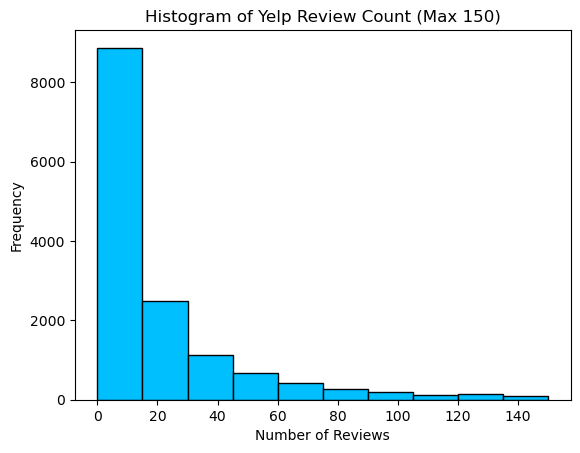

In [5]:
# histograms of review_count
fig, ax = plt.subplots()

tor_bsn['review_count'].plot(ax=ax, kind='hist', color='deepskyblue', edgecolor='black', grid=False, title='Histogram of Yelp Review Count (Max 150)', range=(0,150))
plt.xlabel('Number of Reviews')


As demonstrated by the summary statistics table, review_count has significant right skew. Ignoring businesses with more than 150 reviews yields a clearer picture: the distribution of reviews is unimodal with a peak between 0 and ~15. Given the lack of variation, the number of reviews may not be a significant determinant of business ratings. In other words, the variation in business ratings cannot be meaningfully explained by the number of reviews alone because the majority of businesses are very similar in this dimension. This variable must be used in a multiple regression alongside additional covariates to generate statistically significant coefficients and identify the relevant determinants of business ratings.


/Users/thomas/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Yelp Rating')

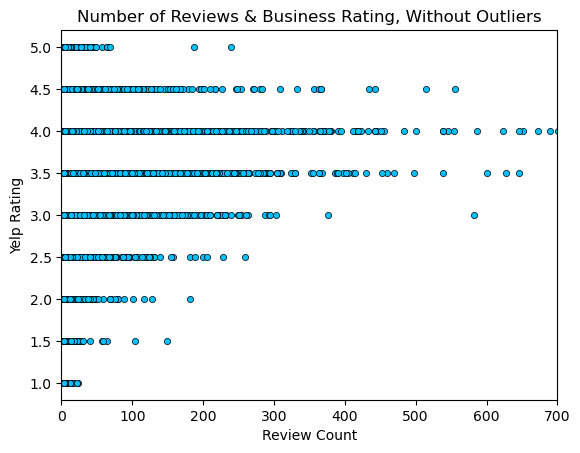

In [6]:
# relationship between business rating and review count
fig, ax = plt.subplots()

tor_bsn.plot(ax=ax, kind='scatter', c='deepskyblue', edgecolor='black', x='review_count', y='stars', xlim=(0,700), title='Number of Reviews & Business Rating, Without Outliers', linewidth=0.5)
plt.xlabel('Review Count')
plt.ylabel('Yelp Rating')

This scatter plot demonstrates that a business's number of reviews is positively correlated with the business's rating. This suggests that the effect of good service dominates the effect of bad service in regard to generating reviews for businesses. If the poorest quality businesses had the greatest number of reviews, then the effect of bad service would dominate. There appears to be non-linearity in this relatationship: the marginal benefit of an additional review decreases significantly between the 200 and 300 review marks. However, this non-linearity may simply be a result of the data for *stars* being discrete. The true effect of the number of reviews on a business's rating is not clear through this plot. Controlling for additional variables, such as the number of checkins on average per day (i.e. customer perception), may present a relationship that differs from the one seen here. 

<AxesSubplot: title={'center': 'Density of Operating Hours: 1* vs. 5* Businesses'}, xlabel='Operating Hours per Week', ylabel='Density'>

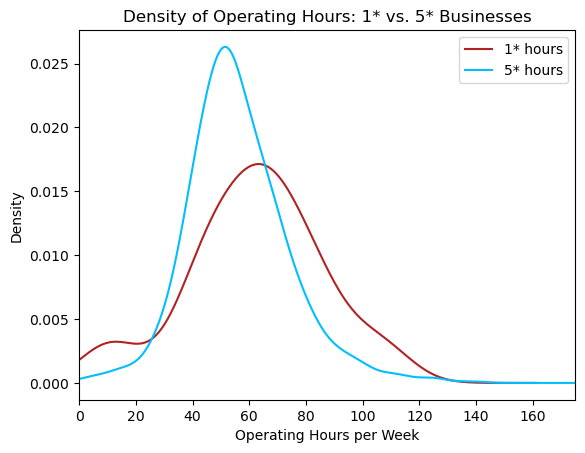

In [7]:
# density of operating hours for businesses with 1*, 5* reviews
tor_1s = tor_bsn.groupby('stars').get_group(1).rename(columns={'wk_op_hours': '1* hours'})
tor_1s = tor_1s[tor_1s['1* hours'] != 0]
tor_5s = tor_bsn.groupby('stars').get_group(5).rename(columns={'wk_op_hours': '5* hours'})
tor_5s = tor_5s[tor_5s['5* hours'] != 0]

tor_1s['1* hours'].plot(kind='kde', c='firebrick', legend=True, title='Density of Operating Hours: 1* vs. 5* Businesses', xlim=(0,175)).set_xlabel("Operating Hours per Week")
tor_5s['5* hours'].plot(kind='kde', c='deepskyblue', legend=True)

This density plot demonstrates how weekly operating hours differ across businesses at either end of the rating spectrum. Five-star businesses are more likely to have between 45-65 hours of operation in any given week and a narrower spread than one-star businesses. On the contrary, one-star businesses have much more variation and are more likely to have less than 30 hours of operation. This evidences the hypothesis that customer access plays a role in determining business ratings. This density plot ignores businesses that had no weekly operating hours listed on Yelp in order to portray a clearer picture of the spread of operating hours across ratings.  
The wider variation in operating hours per week for one-star businesses suggests that there are more one-star businesses than five-star businesses that operate for more than 70 hours per week. This may be random noise, but it could indicate that businesses' hours of operation are weakly correlated with their ratings. In other words, hours of operation may be a poor determinant of business ratings. In order to  identify the strength of a correlation between operating hours and ratings, a linear regression should be done with these two variables.

/Users/thomas/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Yelp Rating')

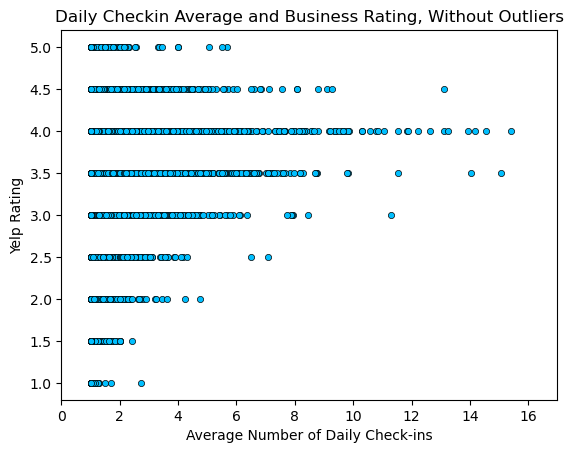

In [8]:
# relationship between businsess rating and checkins
fig, ax = plt.subplots()

tor_bsn.plot(ax=ax, kind='scatter', edgecolor='black', x='daily_checkin_avg', y='stars', c='deepskyblue', title='Daily Checkin Average and Business Rating, Without Outliers', linewidth=0.5).set_xlim(0, 17)
plt.xlabel('Average Number of Daily Check-ins')
plt.ylabel('Yelp Rating')

There is a clear positive association between the average number of check-ins per day and the business rating. Non-linearity also appears to be present but this may be a result of business ratings being measured discretely. There are several massive outliers beyond roughly 17 average check-ins per day, which should be excluded from a formal regression analysis as they exacerbate the non-linear trend. Overall, this relationship is very similar to that of the total number of reviews and business ratings. As a result, controlling for both variables in a regression may be redundant and reduce power. The average daily check-in variable is likely to be a worse predictor of business ratings than the count of reviews since it has relatively less variation.

Using the check-in data as a covariate may present issues with reverse causation as well. Assuming customers use the check-in feature to boast about the businesses they visit, a higher Yelp rating would increase the number of check-ins a business receives. This complicates the identification of a causal relationship between these variables because either the business rating or the average number of check-ins must be used as a dependent variable. Though the issue of reverse causation may not be easily solved with the current dataset, a multiple regression including the other covariates (review_count, wk_op_hours) would provide greater insight into the causality of business ratings.

# Project 2  
## The Message  
What are the most relevant determinants of a business's Yelp Rating, and do they differ depending on the type of business?

/Users/thomas/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


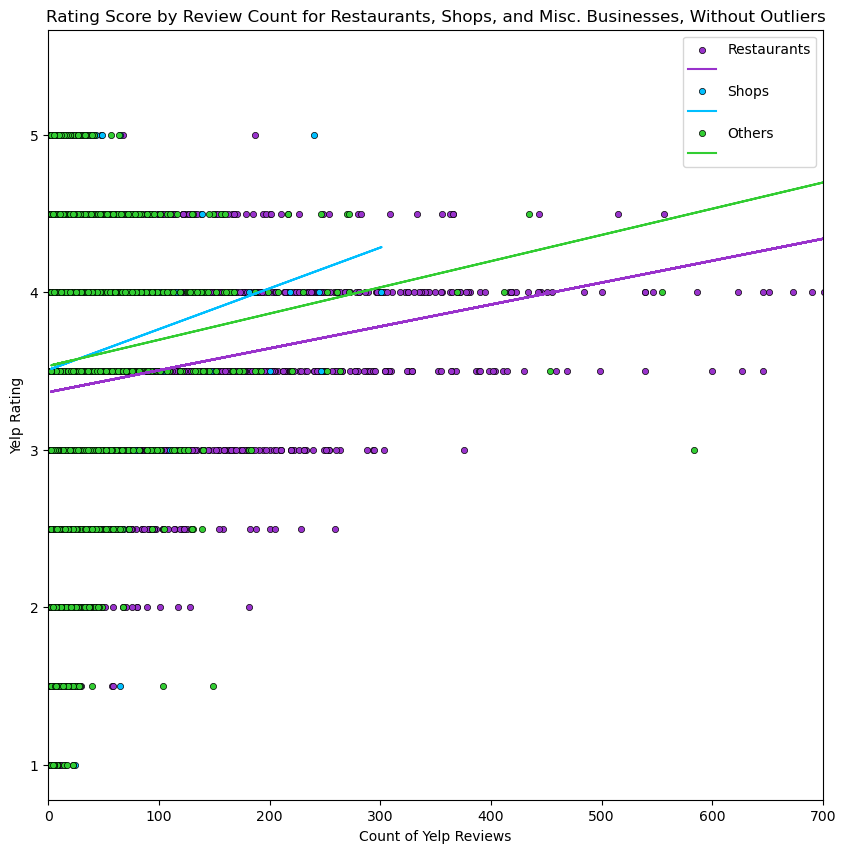

In [9]:
# build scatter plot with stars, review_count for restaurants, shops, miscellaneous
fig, ax = plt.subplots(figsize=(10,10))


not_rst_shop = tor_bsn[tor_bsn['shop'] == 0]
not_rst_shop = not_rst_shop[not_rst_shop['restaurant'] == 0]

#     # find variables to graph based on business type
rst = tor_bsn[['stars', 'review_count']][tor_bsn['restaurant'] == 1]
shop = tor_bsn[['stars', 'review_count']][tor_bsn['shop'] == 1]
other = not_rst_shop[['stars', 'review_count']]

#     # find line of best fit for each set of variables
rst_x, rst_y = np.polyfit(rst['review_count'], rst['stars'], 1)
shop_x, shop_y = np.polyfit(shop['review_count'], shop['stars'], 1)
other_x, other_y = np.polyfit(other['review_count'], other['stars'], 1)

# store relevant data
types_d = {'Restaurants': (rst, rst_x, rst_y, 'darkorchid'),
           'Shops': (shop, shop_x, shop_y, 'deepskyblue'),
           'Others': (other, other_x, other_y, 'limegreen')}

for _type in types_d:
    data, x, y, col = types_d[_type]
    data.plot(ax=ax, kind='scatter', x='review_count', y='stars', c=col, edgecolor='black', linewidth=0.5)
    plt.plot(data['review_count'], (x*data['review_count']+y), c=col)

plt.title('Rating Score by Review Count for Restaurants, Shops, and Misc. Businesses, Without Outliers')
plt.xlabel('Count of Yelp Reviews')
plt.ylabel('Yelp Rating')
plt.xlim(0, 700)
plt.legend(['Restaurants', '', 'Shops', '', 'Others', ''])

This scatter plot demonstrates the relationship between a business's count of Yelp reviews and its Yelp rating. Different colours are used to portrary different types of businesses: restaurants are in purple, shops are in blue, and miscellaneous (non-shops, non-restaurants) are in green. Each type of business also has its own line of best fit, which is calculated with the OLS method. This plot ignores outliers that have more than 700 reviews.  
  
The lines of best fit suggest that the relationship between the count of Yelp reviews and the Yelp rating is very similar for restaurants and miscellaneous businesses. That is, a restaurant or miscellaneous business that has ~200 more reviews is observed to have a Yelp rating that is 0.25 stars higher on average. Moreover, restaurants have the lowest average ratings when compared to shops and miscelleaneous businesses. Holding the number of reviews constant, the expected rating for a restaurant is roughly 0.2 stars lower than for a shop or a miscellaneous business. It is unclear why restaurants have the lowest average reviews, but it is likely related to the particularities of the food industry. For instance, poor-quality food may make customers more likely to leave unfavourable reviews compared to poor-quality service at a miscellaneous business – perhaps because bad food is more tangible.  

Businesses that are not restaurants nor shops include industries like hospitality, service, and banking. These types of businesses likely have a higher Yelp rating on average because the services they offer are even more tangible than food. For instance, an especially good haircut or comfortable hotel bed may overjoy customers to the point that they leave an extra-positive review. However, this category lacks specificity. Without knowing exactly which types of businesses skew the average Yelp rating and in which directions, no firm conclusions can be drawn about the businesses in this category.


Shops seem to have the largest positive correlation between their number of reviews and their rating: they are observed to have a 0.5 higher rating when they have ~200 more reviews. These types of businesses also have many fewer reviews than restaurants and miscellaenous businesses on average. The shop with the most reviews has only ~300 reviews. The correlation's large magnitude may be a result of low sample size, since this graph does not indicate how many observations are in each business category. It could also be that the count of Yelp reviews is truly a more significant determinant of Yelp ratings for shops because 'good service' in these industries is very tangible; as a city with so many stores, it may be easy for customers to recognize above-average service when they experience it.  
  
All in all, this plot provides significant insight with regard to this paper's main message. It demonstrates that the number of Yelp reviews a business has is correlated with its Yelp rating and is therefore a relevant determinant. Moreover, it shows that the effect of a determinant of ratings likely depends on the type of business – at least in the case of review counts. 





## Maps and Interpretations  


In [10]:
# use toronto business data with postal code, longitude, latitude columns
df = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/toronto_businesses.csv')
df = df.copy()

# drop irrelevant postal codes
for i in range(2):
    df.drop(df['longitude'].idxmax(), axis=0, inplace=True)

# build geometry column
df['coordinates'] = list(zip(df['longitude'], df['latitude']))
df['coordinates'] = df['coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='coordinates')

# clean postal_code column for merge
gdf['postal_code'] = gdf['postal_code'].str[:3]

# import shp file
toronto = gpd.read_file('/Users/thomas/Documents/schoolwork/eco225/shp/lfsa000a21a_e/lfsa000a21a_e.shp')
toronto = toronto.rename(columns={'CFSAUID': 'postal_code'})

# drop more irrelevant postal codes
toronto = toronto[toronto['PRNAME'] == 'Ontario']

# ratings map
gdf_stars = gdf.groupby('postal_code')[['stars']].mean()
t_stars = toronto.merge(gdf_stars, how='inner', on='postal_code')

# review count map
gdf_reviews = gdf.groupby('postal_code')[['review_count']].mean()
t_reviews = toronto.merge(gdf_reviews, on='postal_code')

# checkins map
gdf_checks = gdf.groupby('postal_code')[['daily_checkin_avg']].mean()
t_checks = toronto.merge(gdf_checks, on='postal_code')

# gdf.to_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/master/geodata_toronto.csv', index=False) # save gdf

Text(0.5, 1.0, 'Average Yelp Rating by Postal Code for Toronto Businesses')

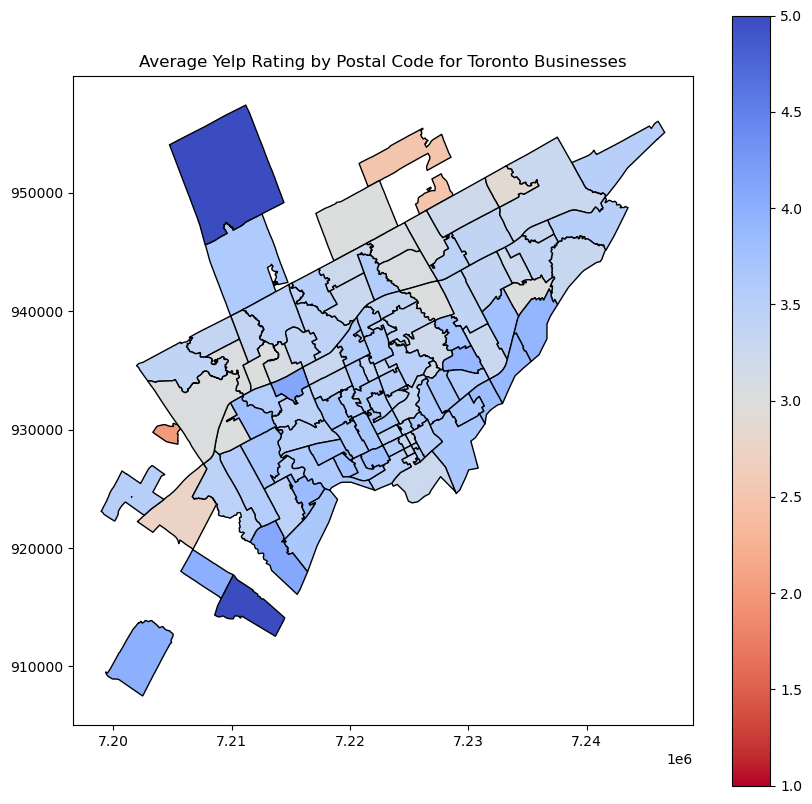

In [11]:
# plotting code for ratings maps
fig, gax = plt.subplots(figsize=(10,10))
t_stars.plot(ax=gax, edgecolor='black', column='stars', cmap='coolwarm_r', vmin=1, vmax=5, legend=True)

plt.title('Average Yelp Rating by Postal Code for Toronto Businesses')

The map of average Yelp ratings by postal code demonstrates that physical geography does not play a significant role in determining Toronto businesses' ratings. Most postal codes have very typical ratings, especially in regions with greater population density. Outliers become more common as distance from downtown increases, but the direction of these outliers seems to be random. This suggests that the prominence of outliers may be the result of each business having relatively fewer reviews. With fewer reviews in these regions, the expected rating is more likely to deviate from the true mean rating.

Text(0.5, 1.0, 'Average Number of Yelp Reviews by Postal Code for Toronto Businesses')

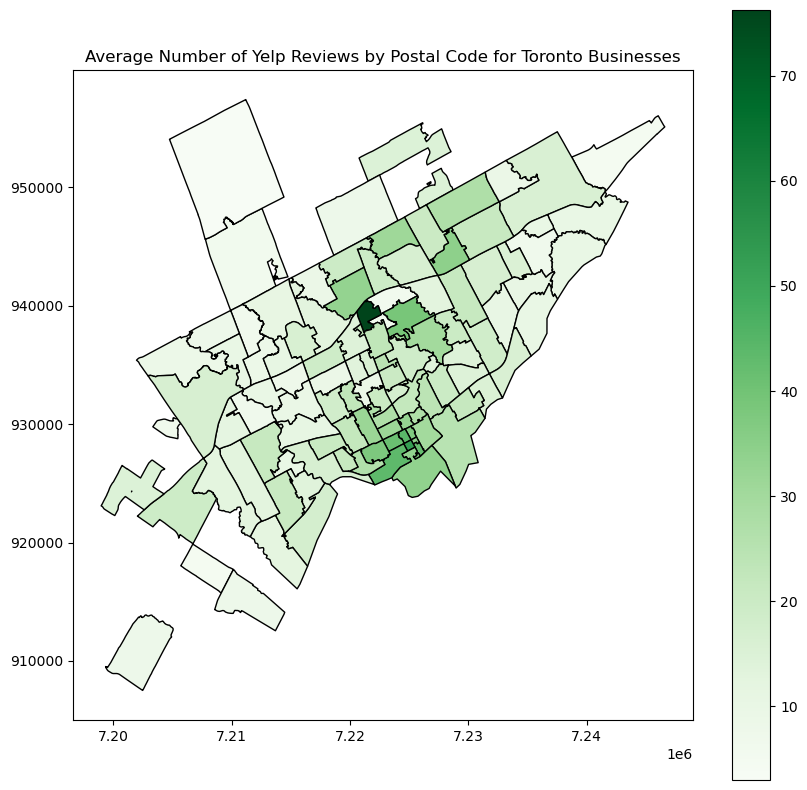

In [12]:
# plotting code for operating hours map
fig, gax = plt.subplots(figsize=(10,10))
t_reviews.plot(ax=gax, edgecolor='black', column='review_count', cmap='Greens', legend=True)

plt.title('Average Number of Yelp Reviews by Postal Code for Toronto Businesses')


Contrary to the map of average Yelp ratings, the average number of Yelp reviews seems to be influenced by geography. The postal codes with the highest average number of reviews are seen in regions with the highest population density, such as those in downtown Toronto. This is rather obvious; businesses that operate in areas with high population density will have more potential customers than thoe in low-density regions. This hints at why this paper has been unable to identify a significant positive correlation between the count of reviews and Yelp ratings: without controlling for population density, businesses in regions with larger populations will see more reviews on average regardless of their actual quality. Including a variable that measures the population for each postal code in a regression with the count of reviews would therefore increase the chances of finding a significant relationship between review count and ratings. The population variable would control for the amount of potential customers that businesses may have, thereby isolating the effect of an additional review on ratings.

Text(0.5, 1.0, 'Average Number of Check-ins per Day by Postal Code for Toronto Businesses')

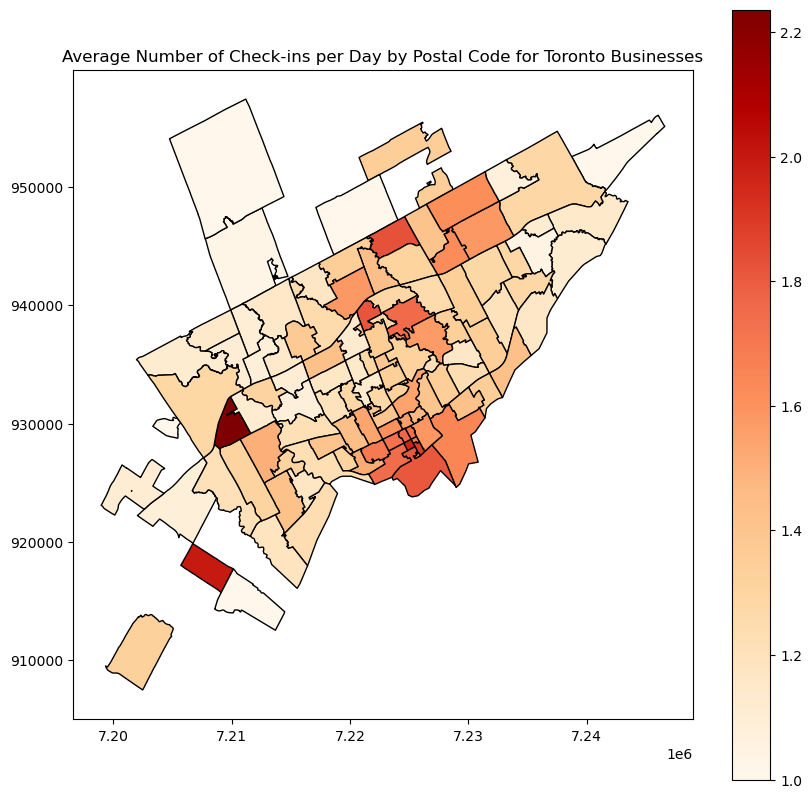

In [13]:
# plotting code for checkins map
fig, gax = plt.subplots(figsize=(10,10))
t_checks.plot(ax=gax, edgecolor='black', column='daily_checkin_avg', cmap='OrRd', legend=True)

plt.title('Average Number of Check-ins per Day by Postal Code for Toronto Businesses')

Similar to the map for average number of reviews, the number of Yelp check-ins a business gets appears to be influenced by geography. The businesses that are located in regions of greater population density, such as downtown, have more check-ins per day on average. However, the  number of check-ins seems to be much more volatile than the number of reviews. This map has outliers of greater magnitude and with greater frequency since many postal codes outside of downtown seem to have high average daily check-in counts. This is likely because check-ins are used infrequently on Yelp to begin with. It does not take much for a business to have a much higher average number of check-ins, especially when the mean for Toronto is 1.5 per day. One especially passionate customer could raise the average number of check-ins per day by 1 on their own. This hypothetical example is especially plausible for restaurants, since returning customers are commonplace in the food industry.

# Project 3

## Potential Data to Scrape
The purpose of this analysis is to identify the determinants of business ratings on Yelp and how these determinants vary across types of businesses. A relevant metric that this paper has been unable to capture so far is the price of products sold by businesses. Often, the price of a product is a significant factor in a consumer's decision to buy. There are two hypotheses for the effect of prices on Yelp ratings. Firstly, the cheap-positive hypothesis: cheaper products may be positively correlated with business ratings. Customers who spend less money on a purchase may make them happier, which in turn improves their perspective on the quality of the quality of the business they were shopping at. Furthermore, customers can shop more frequently at businesses that are affordable. Repeat customers may be more likely to leave positive reviews. On the other hand, the expensive-positive effect may dominate. Cheaper products may suggest low quality for some customers, and would thereby yield negative reviews. By contrast, businesses that sell high-priced goods often advertise themselves as being high-quality. This may affect customer perception and lead to better reviews, even if the objective quality of whatever good or service being transacted is no greater than that of a cheaper alternative. So regardless of a business's price level, it will appeal to some customers and repel others. Including business price level in this analysis would help identify whether the cheap-positive or expensive-positive effect dominates with regard to a business's Yelp rating. This would provide a clearer picture of the determinants of Yelp ratings. The price level of a business is also an important control variable for a multiple regression in this analysis. For example, cheaper businesses may see more customers on average compared to expensive businesses which suggests that cheaper businesses would have more reviews. 

On Yelp, the price level of a business is denoted by an integer quantity of dollar signs. The minimum is one dollar sign, which indicates that the business's good or service is priced low. The maximum is four dollar signs, which suggests that the business is among the most expensive in the region. Examples can be found [here](https://www.yelp.ca/search?find_desc=&find_loc=Toronto%2C+ON). This data can be web scraped using Yelp's Fusion API. This analysis will use a library built to simplify Yelp Fusion for Python, called [yelpapi](https://github.com/lanl/yelpapi). Only Toronto businesses need to be scraped, in accordance with the scope of this study. Once scraped, an outer merge on this analysis's Toronto businesses dataset would provide the number of dollar signs for each business (for which price data is available).


## Potential Challenges
Scraping on Yelp's website is against their terms of service, so performing HTML scraping would be difficult. However, Yelp's Fusion API allows users to access Yelp data free of charge. As a result, the main technical challenge involved with accessing Yelp data is learning how to use Yelp Fusion. Moreover, Yelp Fusion only allows 5000 calls to be made per day per user. Since the dataset it will be merged with has 14 850 businesses, it may take several days before all businesses can be accounted for. This assumes that each business in this dataset actually has price data, which is likely not the case. Additionally, current Yelp data may not represent the state of businesses in 2017, which is when the data that this analysis uses was collected. Relative prices may have increased or decreased since then and many businesses were forced to close during the COVID-19 pandemic. So even if price data can be gathered for most businesses through Yelp Fusion, its relevance to 2017 data may be limited. If there are very few businesses with price data available, then any regressions that are conducted on the dataset would have limited applicability and potential bias.

## Scraping Data from a Website


In [14]:
from yelpapi import YelpAPI

# query API for Toronto businesses
yelp = YelpAPI('WhtldkCQ1Pi_KwG20SCkT4lrN0tELggS0DKVbB6je__22XCVRyKASKtkmgoogNfRQVdgAY7XSsbZ94YSod9Z_F8rrIkCrr5bqHTcoh5tMkBXBZoPFsHsyHCkI3wTZHYx')
ids_ = tor_bsn['business_id']
scraped = []

# for business in ids_[:14850]: # have to run in increments of 5000 ids
#     try:
#         scraped.append(yelp.business_query(business))
#     except:
#         pass # won't exit the loop if the business id can't be found

# save data to a file so I don't have to use more API calls when I want to access it
# code for the first time I saved the data:
# with open('toronto_scraped.json', 'w') as out_file:
#     json.dump(scraped, out_file)

# code for subsequent saves: 
with open('/Users/thomas/Documents/schoolwork/eco225/scraped/toronto_scraped.json', 'r') as f:
    data = json.load(f) # load existing file with data

data.extend(scraped) # add the newly scraped data to the loaded data

with open('/Users/thomas/Documents/schoolwork/eco225/scraped/toronto_scraped.json', 'w') as f:
    json.dump(data, f) # dump all data back into the json

yelp.close() # recommended practice for this api

## Merging the Scraped Dataset

In [15]:
scraped_df = pd.DataFrame(columns=['business_id', 'price_level']) # build dataframe to collect data

# add scraped data to the dataframe
i = 0
with open('/Users/thomas/Documents/schoolwork/eco225/scraped/toronto_scraped.json', 'r') as f:
    data = json.load(f)
    for business in data: # data refers to a list, business refers to a dictionary
        try:
            scraped_df.loc[i] = [business['id'], len(business['price'])]
            i += 1
        except:
            pass # won't exit the loop if the business has no price attribute

tor_df = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/master/geodata_toronto.csv') # load data
tor_price = tor_df.merge(scraped_df, how='outer', on='business_id') # merge data with dataframe
tor_price = tor_price.drop(columns=['Unnamed: 0']) # drop unneeded columns
tor_price['price_level'] = tor_price['price_level'].fillna(0).astype(int) # clean new column

# output to csv: create master dataset
# tor_price.to_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/master/toronto_yelp.csv', index=False)

There are 14 849 observations in this dataset after merging the scraped data.

## Visualizing the Scraped Dataset

Text(0.5, 0, 'Price Level')

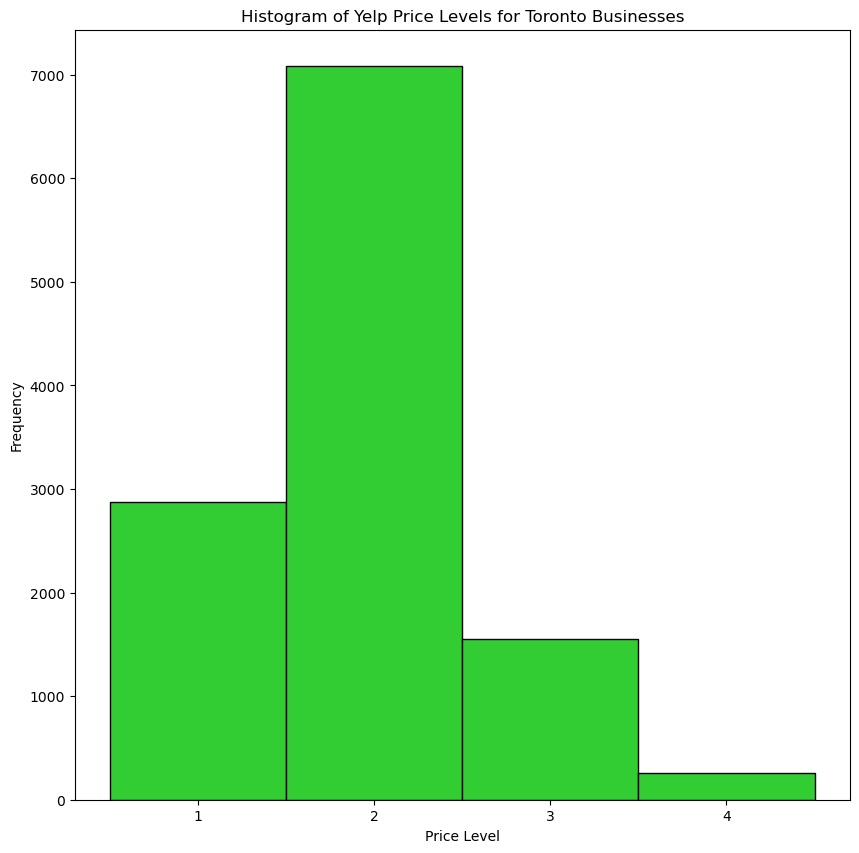

In [16]:
# histogram of price levels
fig, ax = plt.subplots(figsize=(10,10))

tor_price['price_level'].plot(kind='hist', color='limegreen', bins=[0.5, 1.5, 2.5, 3.5, 4.5], ec='black', title='Histogram of Yelp Price Levels for Toronto Businesses')
ax.locator_params(axis='x', integer=True)

plt.xlabel('Price Level')

The price levels of most businesses in Toronto are two dollar signs or below on Yelp. Since there are many more observations at a price level of two or less compared to a price level of 3 or more, this analysis may be unable to determine any relationship between the price level and Yelp ratings. This is because there is a great lack of variation in the data. As the vast majority of businesses have an average price level of roughly 2, a regression including the price level would probably be unable to determine a statistically significant effect.

Text(0.5, 0.98, 'Distribution of Yelp Ratings for Each Price Level')

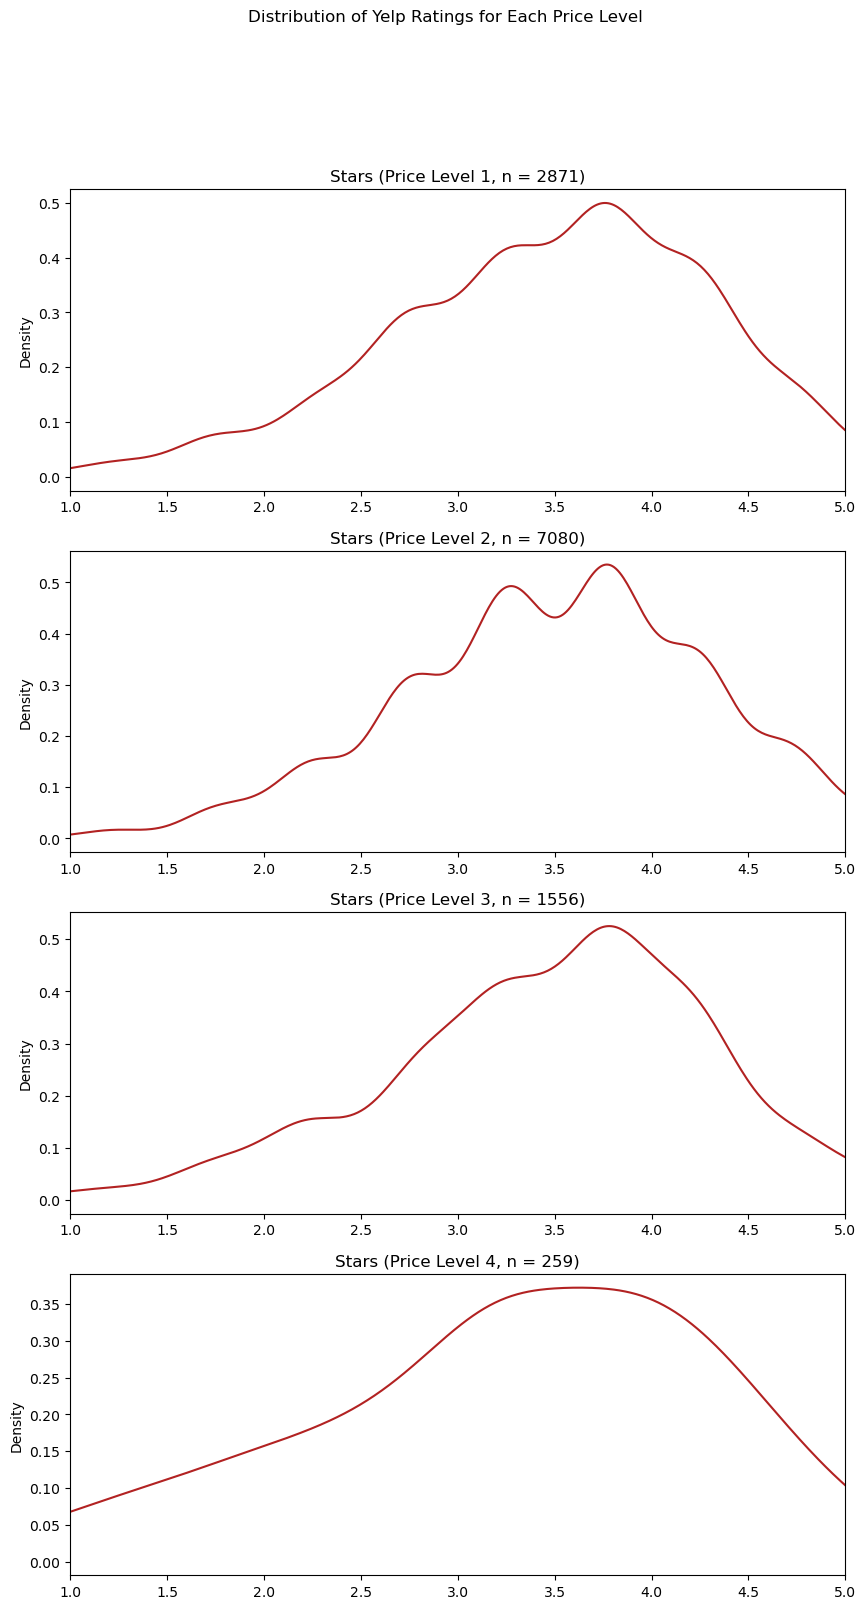

In [17]:
# create jitter for density plot to prevent 
def add_jitter(data: pd.Series, jitter: float) -> pd.Series:
    """adds jitter to data. makes discrete data look more clear on graphs."""
    data = data.copy() # copy the series: don't want to modify it
    jitter_amt = (data.max() - data.min()) * jitter # find amount of jitter to generate: calculated as a % of data's range
    
    for i in range(len(data)):
        data.iloc[i] = (data.loc[i] + np.random.uniform(low=-jitter_amt, high=jitter_amt)) # adds jitter to the data
    
    return data

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,18))

axs = (ax1, ax2, ax3, ax4)

# density plot to see distribution of ratings across price levels
prices_df = [tor_price.loc[tor_price['price_level'] == price] for price in range(1, 5)]

for price_level in range(4):
    data = prices_df[price_level]['stars'].reset_index().drop(columns='index')
    count = data.count()[0]
    stars = add_jitter(data, 0.1)
    stars.plot(ax=axs[price_level], kind='kde', c='firebrick', xlim=(1,5), legend=False).set_title(f"Stars (Price Level {price_level + 1}, n = {count})")

plt.suptitle('Distribution of Yelp Ratings for Each Price Level')

These density plots use jitter to mitigate the serrated pattern that would be otherwise generated, since the price level is a discrete variable. The shape of the distribution of Yelp ratings appears very similar across all price levels. This suggests that the price level is not a determinant of Yelp ratings among businesses in Toronto. The average Yelp rating across all price levels is 3.5, which is approximately the average for each individual price level as well. However, this plot does not demonstrate the strength of this correlation. While Yelp ratings do not necessarily change with the price level, it could be that the price level has precise null effects on the Yelp rating. A formal regression analysis would provide insight in this regard.  

Neither the cheap-positive and expensive-positive hypotheses mentioned in section 3.1 are evidenced by this plot. The lack of an apparent correlation between Yelp ratings and the price level could indicate that both hypotheses are true, but cancel each other out. Some customers dislike businesses with expensive goods while others prefer them. The same may be true for businesses with cheap goods. Therefore, each business will gain and lose customers regardless of how they price their products. A regression model that uses a polynomial term for the price level may present non-linearity and potentially demonstrate if there is a price level sweetspot with regard to the maxmization of Yelp ratings.

## Adding a New Dataset
This data was acquired from [Statistics Canada](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A). It lists the population of each forward sortation area (FSA) in Canada. The first three characters of Canadian postal codes refer to the FSA, which means this data can be merged with this analysis's datasets on the postal code. Following the inferences made in section 2.2, population may be causing omitted variable bias in identifying the magnitude of the effect of the number of Yelp reviews on the Yelp rating for Toronto businesses. By including a population variable in the dataset, the relationship between population, the number of reviews, and ratings can be determined. 



In [18]:
# merge population data
pop_df = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/fsa_pop/fsa_pop.CSV') # load population data
tor_df = pd.read_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/master/toronto_yelp.csv') # load master data

pop_df = pop_df[['Geographic code', 'Population, 2016']]
pop_df = pop_df.rename(columns={'Geographic code': 'postal_code', 'Population, 2016': 'postal_pop'})
tor_pop = tor_df.merge(pop_df, how='inner', on='postal_code') # recall GDF refers to the dataframe with all variables and geo data

# save to csv
# tor_pop.to_csv('/Users/thomas/Documents/schoolwork/eco225/yelp_data/master/toronto_yelp.csv', index=False)

/Users/thomas/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Review Count')

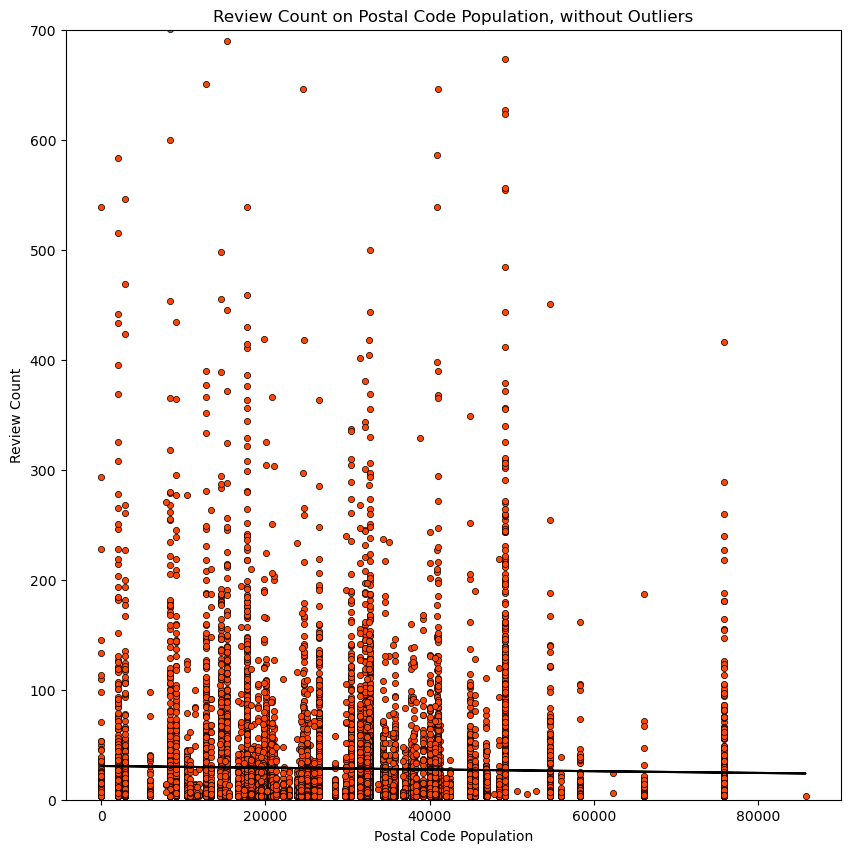

In [19]:
# build visualizations for population

# scatter pop with review count to see if it is confounding
fig, ax = plt.subplots(figsize=(10,10))

tor_pop.plot(ax=ax, kind='scatter', x='postal_pop', y='review_count', color='orangered', ec='black', linewidth=0.5, ylim=(0,700), title='Review Count on Postal Code Population, without Outliers')

# trendline
pop_x, pop_y = np.polyfit(tor_pop['postal_pop'], tor_pop['review_count'], 1)
plt.plot(tor_pop['postal_pop'], (pop_x*tor_pop['postal_pop']+pop_y), c='black')

plt.xlabel('Postal Code Population')
plt.ylabel('Review Count')

This plot demonstrates that there is no correlation between the population of a postal code and the number of reviews for businesses in Toronto. Therefore, the hypothesis proposed by section 2.2 is not substantiated. However, it does not prove that the population is not a confounding variable in this paper's analysis of business ratings. Population may still be correlated with another determinant of business ratings, such as the daily average number of check-ins. Alternatively, population may itself be a determinant of business ratings. This likely means that the determinants for a business's number of a reviews  depends on the quality of the business, its products, and its service as opposed to their characteristics of its locality.

Text(0, 0.5, 'Yelp Rating')

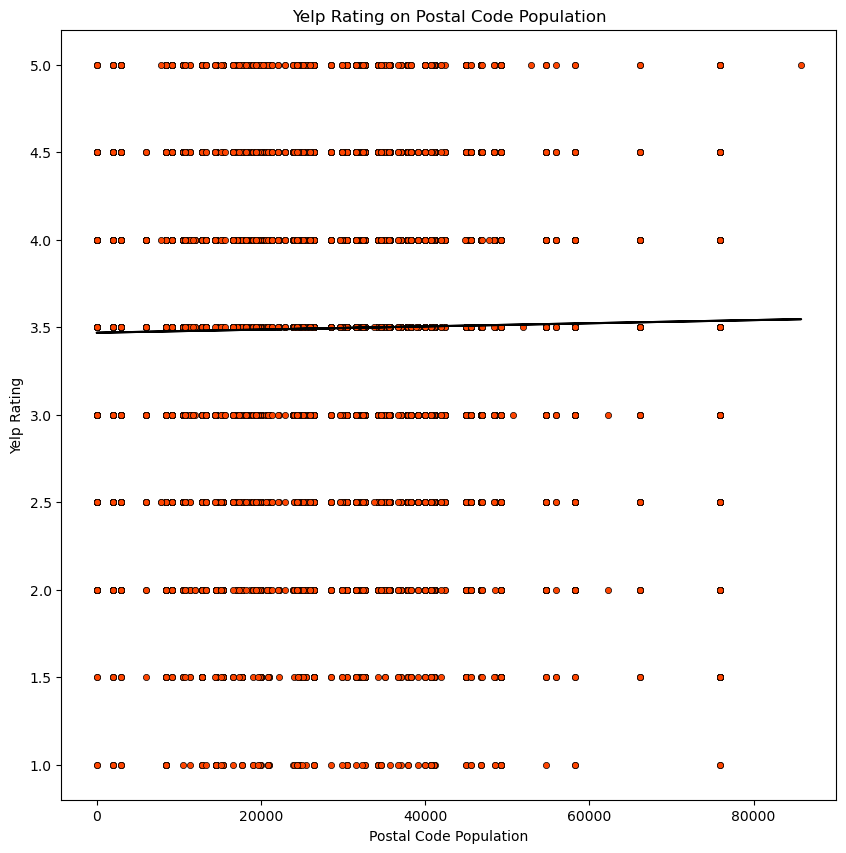

In [20]:
# scatter pop with rating to see if it is a determinant
fig, ax = plt.subplots(figsize=(10,10))

tor_pop.plot(ax=ax, kind='scatter', x='postal_pop', y='stars', color='orangered', ec='black', linewidth=0.5, title='Yelp Rating on Postal Code Population')

# trendline
pop_x, pop_y = np.polyfit(tor_pop['postal_pop'], tor_pop['stars'], 1)
plt.plot(tor_pop['postal_pop'], (pop_x*tor_pop['postal_pop']+pop_y), c='black')

plt.xlabel('Postal Code Population')
plt.ylabel('Yelp Rating')

A business's postal code population appears to be uncorrelated with its Yelp ratings. As a result, it is not a confounding variable in this analysis. This suggests that a business's Yelp rating will be any better or worse depending on the population of its region. This is beneficial to business owners that are seeking to maximize their Yelp rating because good reviews can still be earned while operating in less-busy areas. In theory, lower population areas suggest fewer customers for businesses, fewer necessary hours of operation, and cheaper rent. Should business owners choose to locate themselves in low-density areas, costs can be kept low without making their Yelp ratings suffer.

## Conclusion  
This analysis demonstrates that the number of reviews, weekly hours of operation, and average number of check-ins per day all appear to be positively correlated with business ratings in Toronto on Yelp. In other words, high-quality businesses tend to have more reviews, are open for longer, and receive more check-ins on average relative to poor-quality businesses. Businesses that are located in high-population regions do not seem to gain any advantage or disadvantage with regard to ratings. Similarly, the price level of a business has no identifiable effect on ratings.
  
However, this conclusion can only be drawn from each covariate's relationship with business ratings alone. In other words, the direction of causality among these variables, if any exists, remains unknown. Further, this analysis has not been able to quantify the effects of each covariate on different types of businesses. It is clear that the number of reviews depends in part on a business's industry, and the same is likely true of operating hours and check-ins. The price level and population of a business's FSA does not seem to cause omitted variable bias. That said, other unidentified variables may. A broader set of covariates should be controlled for in order to more precisely identify the determinants of Yelp ratings. Overall, this analysis is unable to determine how relevant the chosen covariates are in determining business ratings.

A multiple regression model with these variables would contribute to a better understanding of the causality of business ratings. It allows for control variables which would yield more precision in determining the effects of any individual covariate. Moreover, it would generate an R^2 value to indicate how relevant the covariates are. This would provide insight on whether the total number of reviews, average number of check-ins, population, and price level are relevant predictors, considering they have limited variation. 